To install `abacusutils`, follow the instructions here: `https://github.com/abacusorg/abacusutils`.

For running the HOD scripts, we recommend cloning the repo and installing with:
`git clone https://github.com/abacusorg/abacusutils.git`
`pip install -e .`

Location of currently available halo light cone catalogs: `/global/cscratch1/sd/boryanah/new_lc_halos/halo_light_cones/AbacusSummit_{base,huge}_c000_ph*`                                                                                                               
                                                                                                                    
Available redshifts for the 25 `base` simulation boxes:                                                               
z0.100  z0.250  z0.400  z0.575  z0.800  z1.025  z1.250  z1.475  z1.700  z2.250                                      
z0.150  z0.300  z0.450  z0.650  z0.875  z1.100  z1.325  z1.550  z1.850  z2.500                                      
z0.200  z0.350  z0.500  z0.725  z0.950  z1.175  z1.400  z1.625  z2.000                                              
                                                                                                                    
Available redshifts for the 2 `huge` simulation boxes:                                                               
z0.100  z0.200  z0.300  z0.400  z0.500  z0.650  z0.800  z0.950  z1.100  z1.250  z1.400  z1.550  z1.700  z2.000      
z0.150  z0.250  z0.350  z0.450  z0.575  z0.725  z0.875  z1.025  z1.175  z1.325  z1.475  z1.625  z1.850  z2.250      
                                                                                                                    
Email boryanah@alumni.princeton.edu for requests/questions regarding the halo light cone catalogs.

For more information, see: https://ui.adsabs.harvard.edu/abs/2021MNRAS.tmp.2780H/abstract

In [1]:
import numpy as np
import scipy.stats as scist
#from mpl_toolkits import mplot3d
%matplotlib notebook
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog

Below we load the halo light cone information from `halo_lc_path`. On NERSC, it is currently stored in Boryana's scratch directory. For the tutorial, I've copied a handful of files locally. `halo_box_path` shows what the equivalent call would be for the box halo catalogs. 

In addition to all the standard fields one can load in the box, the light cone catalogs also contain a few other useful fields: `pos_interp`, `vel_interp`, `N_interp`, `redshift_interp`, `pos_avg`, `vel_avg`, `origin`, `index_halo`, which in some cases should be used in place of the standard fields (e.g. `x_L2com` should be superseded by `pos_interp` or `pos_avg`). Note: all the halo light cone catalogs are already `cleaned`.

Particle `A` subsamples are available at all redshift epochs (in contrast with the box catalogs) with particle positions and velocities taken directly from the light cone outputs.

In [2]:
#halo_lc_path = "/global/cscratch1/sd/boryanah/new_lc_halos/halo_light_cones/AbacusSummit_base_c000_ph000/z0.200/lc_halo_info.asdf"
halo_lc_path = "/mnt/marvin1/boryanah/tutorial_lc/halo_light_cones/AbacusSummit_base_c000_ph000/z0.200/lc_halo_info.asdf"

# directory to load halo box information (not used in this tutorial)
halo_box_path = "/global/project/projectdirs/desi/cosmosim/Abacus/AbacusSummit_base_c000_ph000/halos/z0.200/"

# fields to load
fields_lc = ["r90_L2com", "r25_L2com", "N_interp", "pos_interp", "vel_interp", "npstartA", "npoutA"]
fields_box = ["r90_L2com", "r25_L2com", "N", "x_L2com", "v_L2com", "npstartA", "npoutA"]

# load halo lc catalog
subsamples = dict(A=True, rv=True)
cat = CompaSOHaloCatalog(halo_lc_path, cleaned=True, subsamples=subsamples, fields=fields_lc)#, halo_lc=True)
assert cat.halo_lc == True

Check out the data contained in `cat`. There are three substructures within it: dictionary `cat.header`, table `cat.halos`, table `cat.subsamples` (empty if `subsamples=False`).

In [3]:
# load header information
Lbox = cat.header['BoxSizeHMpc']
Mpart = cat.header['ParticleMassHMsun']

# print out some values
for key in cat.halos.keys():
    print(cat.halos[key][:1])

r90_L2com
---------
0.2154235
 r25_L2com 
-----------
0.056997467
N_interp
--------
     587
     pos_interp [3]    
-----------------------
-989.84155 .. -619.5034
    vel_interp [3]    
----------------------
-595.888 .. -232.04024
npstartA
--------
       0
npoutA
------
    19


Let's compute the mass-concentration relationship for halos in the halo light cone catalogs.

Text(0, 0.5, 'Concentration')

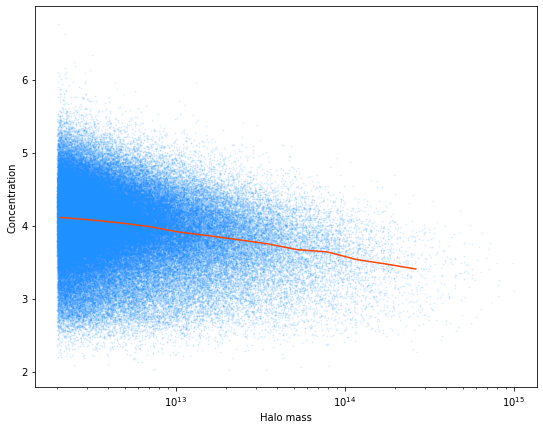

In [4]:
# compute mass and concentration proxy for all halos
halo_mass = cat.halos['N_interp']*Mpart
concentration = cat.halos['r90_L2com']/cat.halos['r25_L2com']
    
# select halos above 2.10^12 Msun/h (1000 particles)
mass_thresh = 2.e12 # Msun/h
choice = halo_mass > mass_thresh

# compute median concentration
bins = np.logspace(11, 14.5, 21)
conc_median, _, inds = scist.binned_statistic(halo_mass[choice], concentration[choice], statistic='median', bins=bins)
binc = (bins[1:]+bins[:-1])*.5

# plot the mass vs. concentration relationship
plt.figure(figsize=(9, 7))
plt.scatter(halo_mass[choice], concentration[choice], s=1, alpha=0.1, color='dodgerblue')
plt.plot(binc, conc_median, color='orangered')
plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("Concentration")

Let's visualize the largest halo in this catalog.

largest mass = 1.00e+15


Text(0, 0.5, 'Y [Mpc/h]')

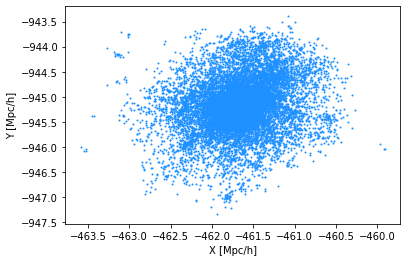

In [5]:
# select the largest halo                                                                                                                                                    
i_max = np.argmax(halo_mass)
print(f"largest mass = {halo_mass[i_max]:.2e}")
start = cat.halos['npstartA'][i_max]
npout = cat.halos['npoutA'][i_max]
pos_max = cat.subsamples['pos'][start:start+npout]
plt.scatter(pos_max[:, 0], pos_max[:, 1], s=1, color='dodgerblue')
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')

Finally, let's plot the halos in this redshift catalog (they live in a thin shell that takes up an octant of the sky).

Text(0.5, 0, 'Z [Mpc/h]')

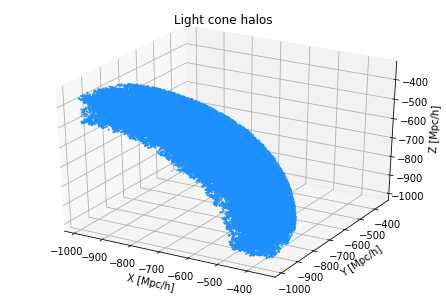

In [6]:
# plot the halos in this redshift catalog                                                                                                                              
halo_pos = cat.halos['pos_interp']

# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
ax.scatter(halo_pos[choice, 0], halo_pos[choice, 1], halo_pos[choice, 2], s=1, color='dodgerblue')
  
# setting title and labels
ax.set_title("Light cone halos")
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
